# Machine Learning I
# Aprendizado Supervisionado
## Escrito por Duncan Ruiz

Prática com Decision Tree Classifier e velha

In [22]:
# pacotes básicos
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# pacotes do sklearn para acesso a datasets, preparação, modelagem e avaliação
from sklearn import datasets
# pacote pipeline para combinar preparação e modelagem
from sklearn.pipeline import Pipeline, make_pipeline
# arsenal de preparação
from sklearn.preprocessing import MinMaxScaler # rescala em min-max
from sklearn.preprocessing import StandardScaler # padroniza features removendo média e
#     escalando para variância unitária. Também chamado de z-score
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold as skf
from sklearn.model_selection import GridSearchCV as gscv
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.tree import plot_tree, export_graphviz, export_text
from sklearn.metrics import accuracy_score as acc_score
from sklearn.metrics import confusion_matrix as cm
from sklearn.metrics import ConfusionMatrixDisplay as CMD
import sklearn.metrics as metrics
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

#pacotes para apoio a leitura e gravação de datasets
from pathlib import Path
import csv

#pacotes para visualização e formatação
import pprint
import graphviz

In [2]:
# carga de dados]
velha = pd.read_csv('amostras_.csv',sep = ';')

In [3]:
# separação em features e target
X = velha.drop(columns=['classe'])
y = velha['classe']

In [4]:
print(X.shape)
print(y.shape)

(750, 9)
(750,)


In [5]:
# separação em treino e teste, e X e y

treino_X, teste_X, treino_y, teste_y = tts(X, y, random_state=0,test_size=0.1, stratify=y)
tr_X, v_X, tr_y, v_y = tts(treino_X, treino_y.to_numpy(), random_state=0,test_size=0.1, stratify=treino_y)

print(treino_X.shape)
print(treino_y.shape)
print(teste_X.shape)
print(teste_y.shape)
print(v_X.shape)
print(v_y.shape)
print(np.stack(np.unique(treino_y, return_counts=True), axis=1))
print(np.stack(np.unique(teste_y, return_counts=True), axis=1))
print(np.stack(np.unique(v_y, return_counts=True), axis=1))

(675, 9)
(675,)
(75, 9)
(75,)
(68, 9)
(68,)
[['Em_jogo' 225]
 ['Fim_de_jogo' 225]
 ['Possibilidade_de_fim_de_jogo' 225]]
[['Em_jogo' 25]
 ['Fim_de_jogo' 25]
 ['Possibilidade_de_fim_de_jogo' 25]]
[['Em_jogo' 23]
 ['Fim_de_jogo' 23]
 ['Possibilidade_de_fim_de_jogo' 22]]


In [6]:
teste_X

,pos1,pos2,pos3,pos4,pos5,pos6,pos7,pos8,pos9
306,-1,1,-1,1,-1,0,0,0,1
732,-1,1,1,1,-1,-1,-1,1,1
562,0,1,-1,0,-1,1,1,-1,1
419,-1,1,-1,1,0,0,1,1,-1
139,1,-1,1,1,-1,0,-1,-1,1
...,...,...,...,...,...,...,...,...,...
25,1,-1,1,-1,1,1,0,-1,0
452,0,1,-1,0,1,-1,0,-1,1
585,-1,1,-1,-1,0,1,1,0,0
136,1,-1,1,1,-1,-1,0,-1,1


VALIDACAO CRUZADA

In [7]:
param_grid = {
        'criterion': ['log_loss','gini','entropy'],
        'min_samples_split': [2,3,4,5,6,7,8,9],
        'min_samples_leaf': [1,2,3,4,5],
        'class_weight': [None, 'balanced'],
        'ccp_alpha': [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09, 0.1]
    }

grid = gscv(
    DTC(),
    param_grid,
    n_jobs=-1,
    cv=10,         # 10-fold cross-validation
    scoring='accuracy'
)
grid.fit(tr_X, tr_y)
print("Melhores parametros:", grid.best_params_)
print("Acurácia média de validação:", grid.best_score_)

Melhores parametros: {'ccp_alpha': 0.005, 'class_weight': None, 'criterion': 'log_loss', 'min_samples_leaf': 1, 'min_samples_split': 4}
Acurácia média de validação: 0.7000273224043715


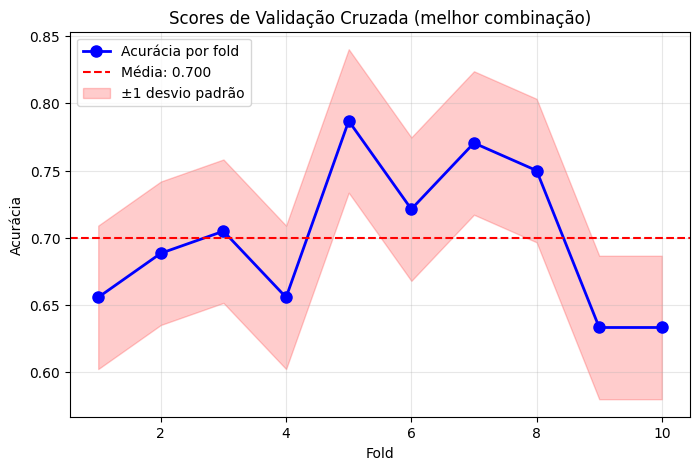

In [41]:
df = pd.DataFrame(grid.cv_results_)

# índice da melhor combinação de hiperparâmetros
best_idx = grid.best_index_

# pega os scores de cada fold para essa combinação
fold_cols = [c for c in df.columns if c.startswith("split") and c.endswith("_test_score")]
fold_scores = df.loc[best_idx, fold_cols].values.astype(float)

# calcula média e desvio padrão
mean_score = fold_scores.mean()
std_score = fold_scores.std()

# plota
plt.figure(figsize=(8,5))
plt.plot(range(1, len(fold_scores)+1), fold_scores, "bo-", linewidth=2, markersize=8, label="Acurácia por fold")

# linha da média
plt.axhline(y=mean_score, color="r", linestyle="--", label=f"Média: {mean_score:.3f}")

# faixa do desvio padrão em torno da média
plt.fill_between(range(1, len(fold_scores)+1),
                 fold_scores - std_score,
                 fold_scores + std_score,
                 alpha=0.2, color="red", label="±1 desvio padrão")

plt.xlabel("Fold")
plt.ylabel("Acurácia")
plt.title("Scores de Validação Cruzada (melhor combinação)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

Matriz de confusao em cruzada


In [8]:
modelo = grid.best_estimator_
modelo.fit(tr_X, tr_y)
cru_pred_y = modelo.predict(v_X)
acc_cru = grid.best_score_

In [9]:
nomes_classes = velha.iloc[:, [9]].values
classes_unicas = np.unique(nomes_classes)
#print(classes_unicas)
mat_cm_cru = metrics.confusion_matrix(v_y, cru_pred_y)

In [10]:
# apresentações do modelo com validacao cruzada
modelo_txt = export_text(modelo, feature_names=velha.drop(columns=['classe']).columns)
print(modelo_txt)

|--- pos3 <= -0.50
|   |--- pos8 <= 0.50
|   |   |--- pos7 <= -0.50
|   |   |   |--- pos5 <= -0.50
|   |   |   |   |--- class: Fim_de_jogo
|   |   |   |--- pos5 >  -0.50
|   |   |   |   |--- pos5 <= 0.50
|   |   |   |   |   |--- pos6 <= 0.50
|   |   |   |   |   |   |--- class: Em_jogo
|   |   |   |   |   |--- pos6 >  0.50
|   |   |   |   |   |   |--- pos4 <= 0.50
|   |   |   |   |   |   |   |--- class: Em_jogo
|   |   |   |   |   |   |--- pos4 >  0.50
|   |   |   |   |   |   |   |--- class: Possibilidade_de_fim_de_jogo
|   |   |   |   |--- pos5 >  0.50
|   |   |   |   |   |--- pos6 <= 0.50
|   |   |   |   |   |   |--- class: Possibilidade_de_fim_de_jogo
|   |   |   |   |   |--- pos6 >  0.50
|   |   |   |   |   |   |--- pos4 <= 0.50
|   |   |   |   |   |   |   |--- class: Possibilidade_de_fim_de_jogo
|   |   |   |   |   |   |--- pos4 >  0.50
|   |   |   |   |   |   |   |--- class: Fim_de_jogo
|   |   |--- pos7 >  -0.50
|   |   |   |--- pos9 <= -0.50
|   |   |   |   |--- pos6 <= -0.50
| 

ARVORE DE DECISAO (CRUZADA)

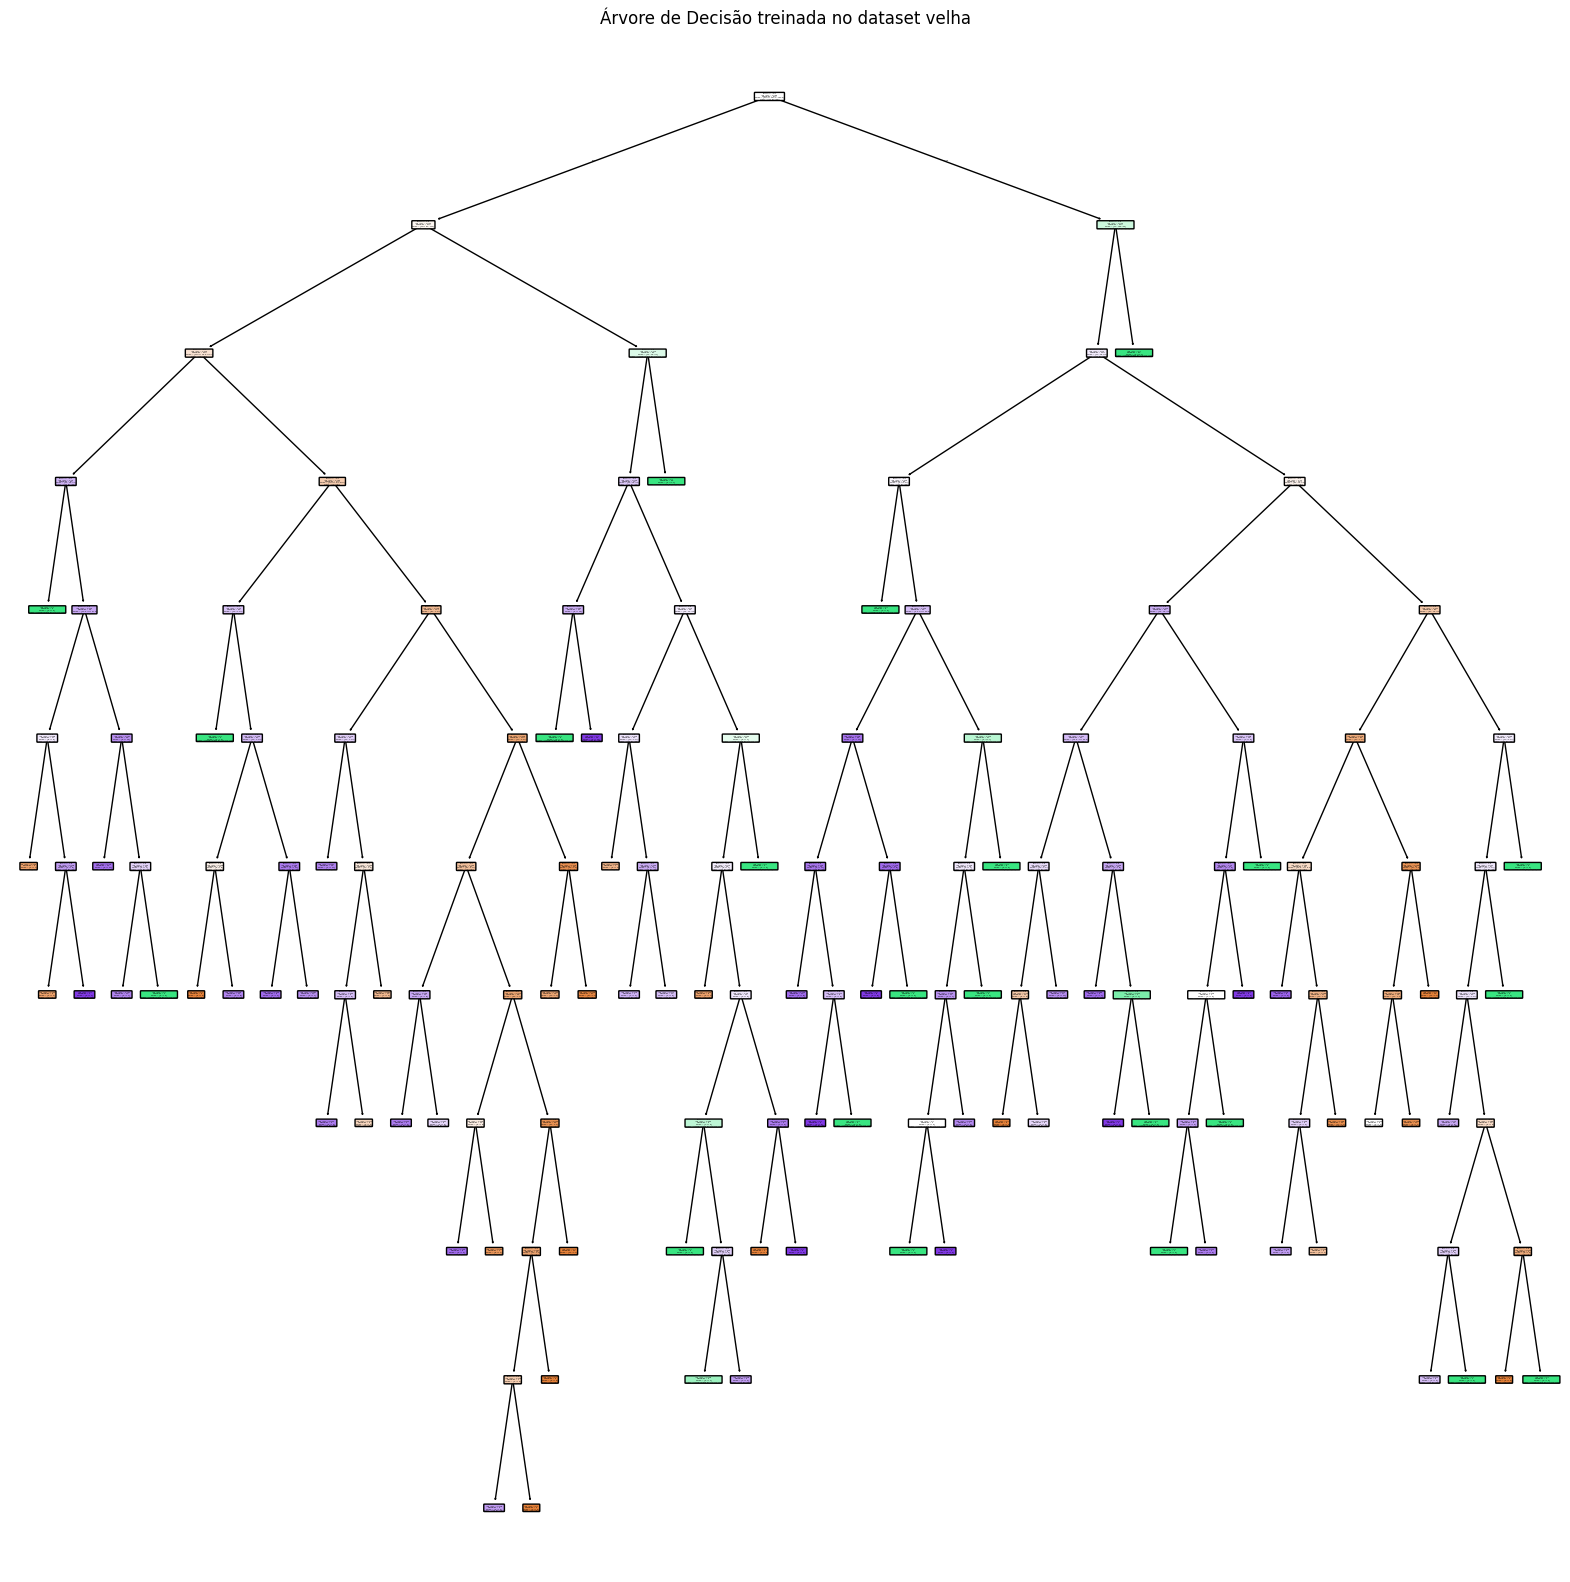

In [11]:
# apresentações do modelo
plt.figure(figsize=(20, 20))
plot_tree(modelo, filled=True, rounded=True, feature_names=velha.drop(columns=['classe']).columns, class_names=['Em_jogo','Possibilidade_de_fim_de_jogo','Fim_de_jogo'])
plt.title('Árvore de Decisão treinada no dataset velha')
plt.show()

VALIDACAO EXPLICITA

In [42]:
# indução do modelo de classificação por árvore de decisão
#ccp_alphas = [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]
ccp_alphas = [0.0, 0.005, 0.01, 0.015, 0.02, 0.025, 0.03, 0.04, 0.05, 0.055, 0.06, 0.07, 0.08, 0.09, 0.1]
#ccp_alphas = [0.055]
#ccp_alphas = [0.0]
melhor_acc = 0
melhor_modelo = None
melhor_cm = None
melhor_alpha = 0
melhor_predicao = None
for ccp_i in ccp_alphas:
    modelo = DTC(random_state=0
                ,criterion='log_loss'  # 'gini', 'entropy', 'log_loss'
                ,min_samples_split=3
                ,min_samples_leaf=1   # default 1
                ,max_leaf_nodes=None  # default None
                ,class_weight='balanced'   # default None. 'balanced' para equilibrar classes
                ,ccp_alpha=ccp_i        # default 0.0 Valores na documentação 0.005 0.01 0.015 0.02 0.025 0.03 0.035
                )
    modelo.fit(tr_X, tr_y)
    v_pred_y = modelo.predict(v_X)
    acuracia = acc_score(v_y, v_pred_y)
    mat_cm = metrics.confusion_matrix(v_y, v_pred_y)
    if acuracia > melhor_acc:
        melhor_acc = acuracia
        melhor_modelo = modelo
        melhor_cm = mat_cm
        melhor_alpha = ccp_i
        melhor_predicao = v_pred_y





print('Alpha=', melhor_alpha,' Acuracia=', melhor_acc)


Alpha= 0.005  Acuracia= 0.7647058823529411


In [43]:
# apresentações do modelo com validacao explicita
modelo_txt = export_text(melhor_modelo, feature_names=velha.drop(columns=['classe']).columns)
print(modelo_txt)

|--- pos3 <= -0.50
|   |--- pos8 <= 0.50
|   |   |--- pos7 <= -0.50
|   |   |   |--- pos5 <= -0.50
|   |   |   |   |--- class: Fim_de_jogo
|   |   |   |--- pos5 >  -0.50
|   |   |   |   |--- pos5 <= 0.50
|   |   |   |   |   |--- pos6 <= 0.50
|   |   |   |   |   |   |--- class: Em_jogo
|   |   |   |   |   |--- pos6 >  0.50
|   |   |   |   |   |   |--- pos4 <= 0.50
|   |   |   |   |   |   |   |--- class: Em_jogo
|   |   |   |   |   |   |--- pos4 >  0.50
|   |   |   |   |   |   |   |--- class: Possibilidade_de_fim_de_jogo
|   |   |   |   |--- pos5 >  0.50
|   |   |   |   |   |--- pos6 <= 0.50
|   |   |   |   |   |   |--- class: Possibilidade_de_fim_de_jogo
|   |   |   |   |   |--- pos6 >  0.50
|   |   |   |   |   |   |--- pos4 <= 0.50
|   |   |   |   |   |   |   |--- class: Possibilidade_de_fim_de_jogo
|   |   |   |   |   |   |--- pos4 >  0.50
|   |   |   |   |   |   |   |--- class: Fim_de_jogo
|   |   |--- pos7 >  -0.50
|   |   |   |--- pos9 <= -0.50
|   |   |   |   |--- pos6 <= -0.50
| 

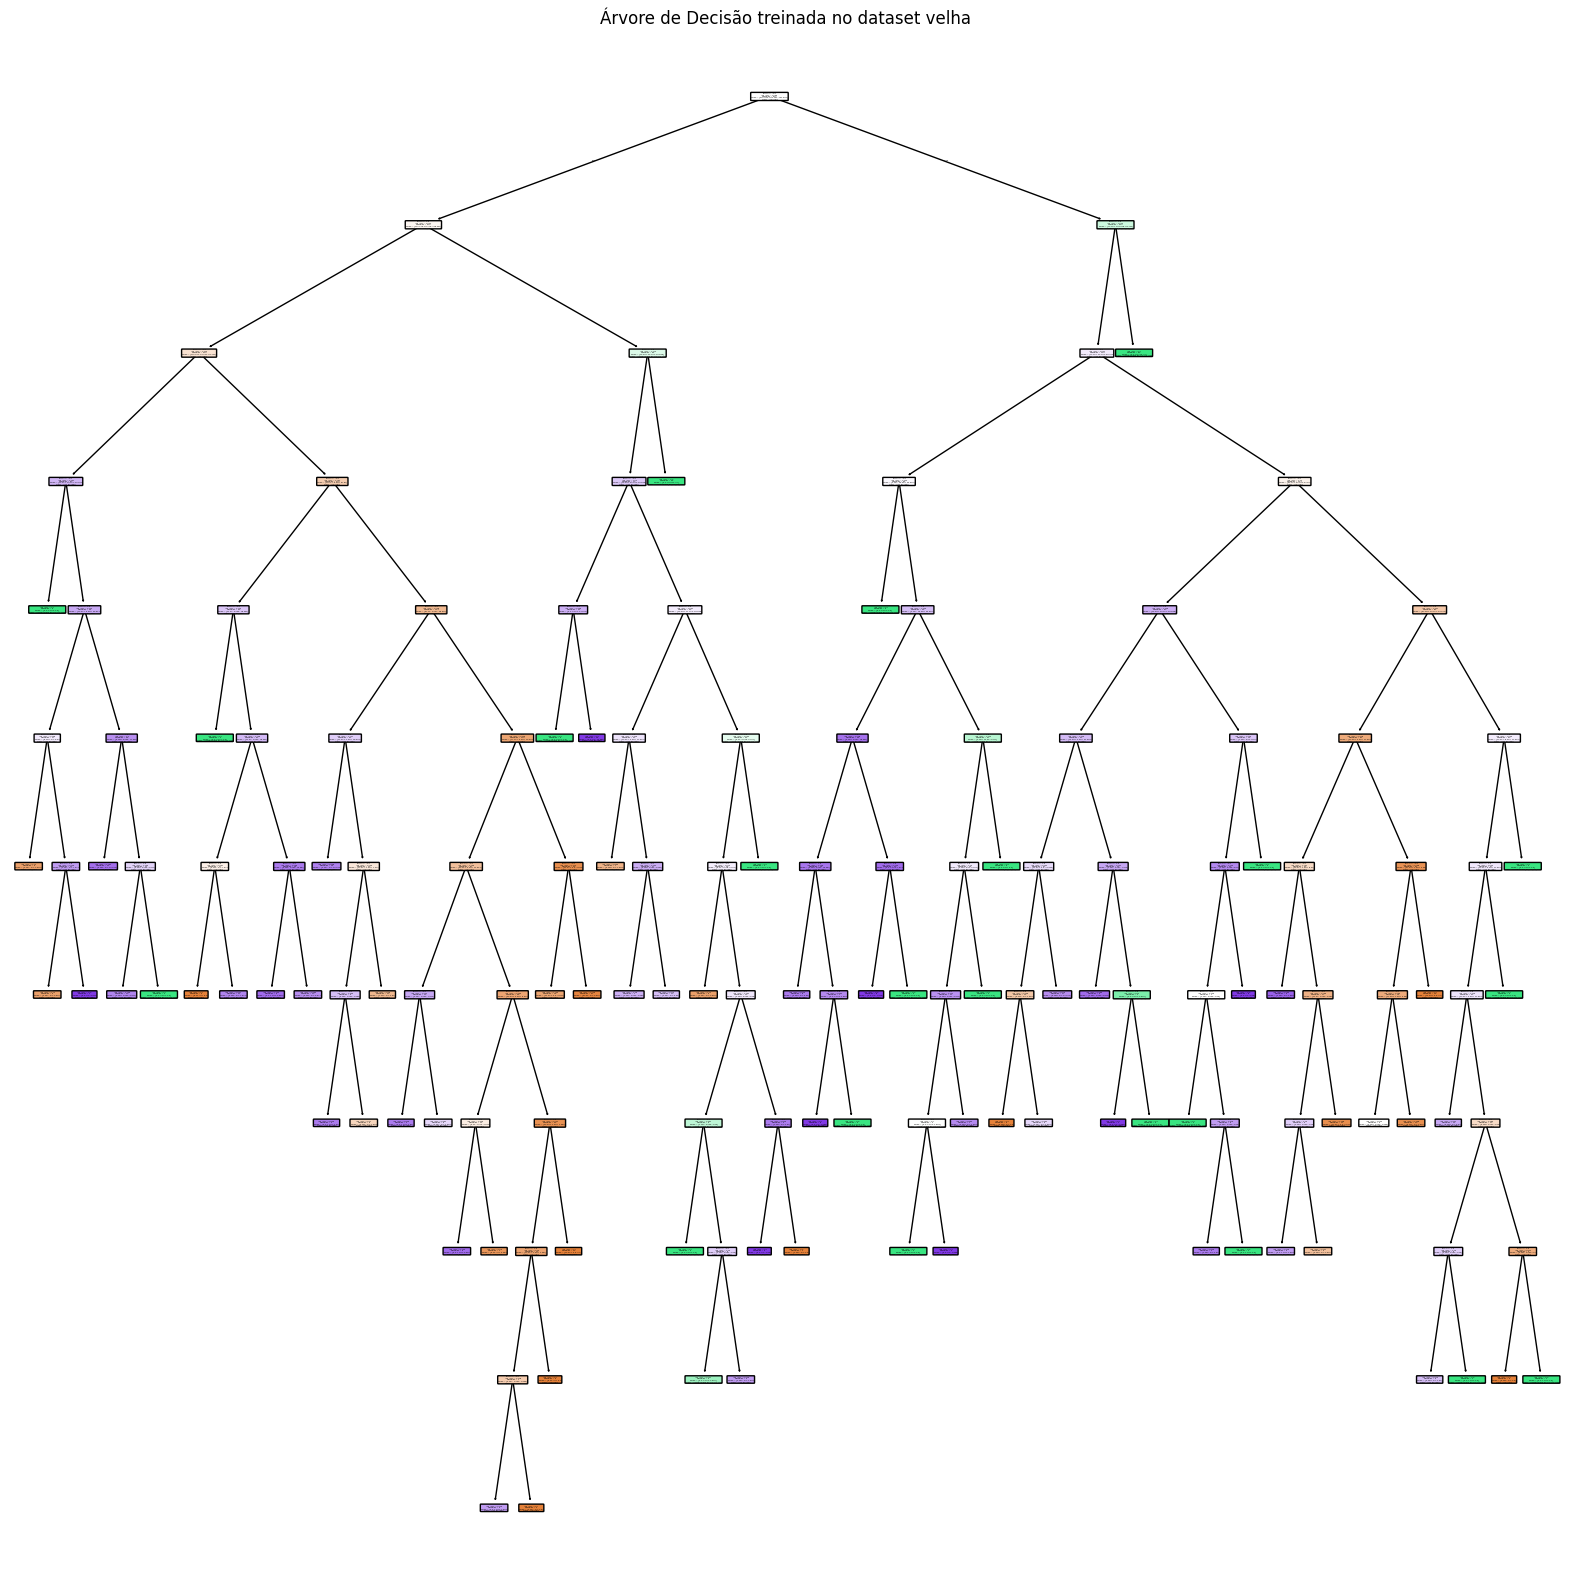

In [44]:
# apresentações do modelo
plt.figure(figsize=(20, 20))
plot_tree(melhor_modelo, filled=True, rounded=True, feature_names=velha.drop(columns=['classe']).columns, class_names=['Em_jogo','Possibilidade_de_fim_de_jogo','Fim_de_jogo'])
plt.title('Árvore de Decisão treinada no dataset velha')
plt.show()


Matriz de Confusao (Explicita)

In [45]:
mat_cm_expl = metrics.confusion_matrix(v_y, melhor_predicao)

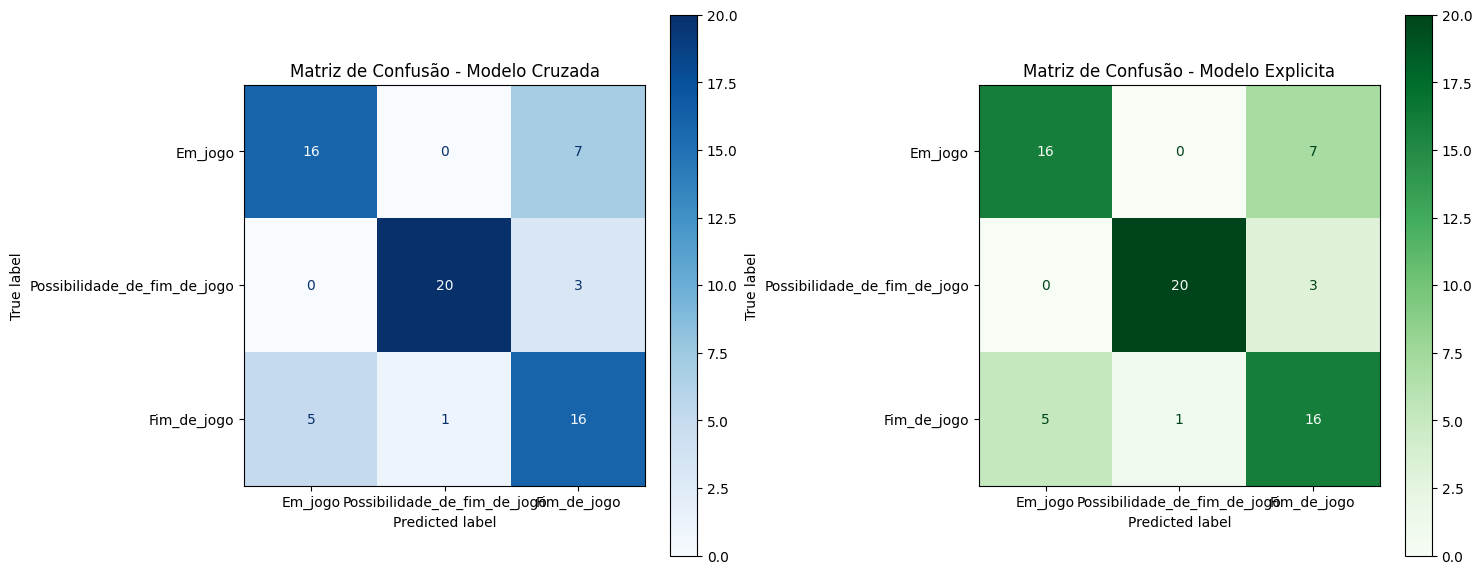

Relatório de Classificação - Modelo Cruzado:
                              precision    recall  f1-score   support

                     Em_jogo       0.76      0.70      0.73        23
Possibilidade_de_fim_de_jogo       0.95      0.87      0.91        23
                 Fim_de_jogo       0.62      0.73      0.67        22

                    accuracy                           0.76        68
                   macro avg       0.78      0.76      0.77        68
                weighted avg       0.78      0.76      0.77        68

Relatório de Classificação - Modelo Explicito:
                              precision    recall  f1-score   support

                     Em_jogo       0.76      0.70      0.73        23
Possibilidade_de_fim_de_jogo       0.95      0.87      0.91        23
                 Fim_de_jogo       0.62      0.73      0.67        22

                    accuracy                           0.76        68
                   macro avg       0.78      0.76      0.77    

In [47]:
nomes_classes = velha.iloc[:, [9]].values
classes_unicas = np.unique(nomes_classes)
#print(classes_unicas)
# usa DataFrame com nomes de features

# Comparação das matrizes de confusão
fig, axes = plt.subplots(1, 2, figsize=(15, 6))

# Matriz Cruzada
disp1 = CMD(
    confusion_matrix=mat_cm_cru, 
    display_labels=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']
)
disp1.plot(ax=axes[0], cmap='Blues', values_format='d')
axes[0].set_title('Matriz de Confusão - Modelo Cruzada')

# Matriz Explicita
disp2 = CMD(
    confusion_matrix=mat_cm_expl, 
    display_labels=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']
)
disp2.plot(ax=axes[1], cmap='Greens', values_format='d')
axes[1].set_title('Matriz de Confusão - Modelo Explicita')

plt.tight_layout()
plt.show()

print("Relatório de Classificação - Modelo Cruzado:")
print(classification_report(v_y, cru_pred_y, target_names=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']))

print("Relatório de Classificação - Modelo Explicito:")
print(classification_report(v_y, melhor_predicao, target_names=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']))



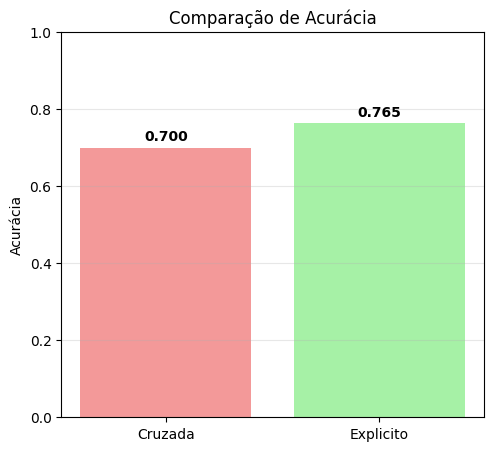

In [48]:
# Visualização da comparação de performance
plt.figure(figsize=(12, 5))

# Gráfico 1: Comparação de acurácias
plt.subplot(1, 2, 1)
models = ['Cruzada', 'Explicito']
accuracies = [acc_cru, melhor_acc]
colors = ['lightcoral', 'lightgreen']

bars = plt.bar(models, accuracies, color=colors, alpha=0.8)
plt.title('Comparação de Acurácia')
plt.ylabel('Acurácia')
plt.ylim(0, 1)

# Adicionar valores nas barras
for bar, acc in zip(bars, accuracies):
    plt.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.01, 
             f'{acc:.3f}', ha='center', va='bottom', fontweight='bold')

plt.grid(True, alpha=0.3, axis='y')

In [52]:
a = grid.best_estimator_
a.fit(tr_X,tr_y)
y_pred = a.predict(teste_X)
acuracia = acc_score(teste_y, y_pred)
print(f'Acuracia {acuracia}')


Acuracia 0.68


In [54]:
print("Relatório de Classificação - Testes:")
print(classification_report(teste_y, y_pred, target_names=['Em_jogo', 'Possibilidade_de_fim_de_jogo', 'Fim_de_jogo']))


Relatório de Classificação - Testes:
                              precision    recall  f1-score   support

                     Em_jogo       0.65      0.60      0.62        25
Possibilidade_de_fim_de_jogo       0.88      0.84      0.86        25
                 Fim_de_jogo       0.54      0.60      0.57        25

                    accuracy                           0.68        75
                   macro avg       0.69      0.68      0.68        75
                weighted avg       0.69      0.68      0.68        75

